In [1]:
from matplotlib import pyplot as plt
import scipy.sparse
import scipy.special
from tqdm import *
import seaborn as sns
from quimb import *
import quimb.tensor as qtn
import numpy as np
from pynverse import inversefunc
import networkx as nx
from qiskit import quantum_info as qi
import functools 
import scienceplots

sns.set_context("paper")
sns.set_style("whitegrid")
plt.style.use(['science'])
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman"],
#     "figure.titlesize": 11.5,
#     "axes.titlesize": 11.5,
#     "axes.labelsize": 8,
#     "xtick.labelsize": 7.5,
#     "ytick.labelsize": 7.5,
#     "legend.fontsize": 8,
#     "font.sans-serif": ["Computer Modern Sans Serif"]})
width = 469/72
ratio = (1+np.sqrt(5))/2

def comm(A, B):
    return A @ B - B @ A

def it_comm(A, B, n=1):
    ret = B
    for i in range(n):
        ret = comm(A, ret)
    return ret

def cheb_times(A, L):
    l = np.arange(1,L+1)
    z = -np.cos((2*l-1)/(2*L)  * np.pi)
    return A/2 * (1+z)

def inv_map(d):
    ret = {}
    for k, v in d.items():
        ret.setdefault(v, []).append(k)
    return ret

paulis = np.array(['X', 'Y', 'Z'])
stabilizers = np.concatenate([np.linalg.eigh(pauli(p))[1] for p in paulis])


In [2]:
import scipy.special
def noise_pred(L, A):
    return 4*(L-1)*(2*L-1)*(3*L**2-3*L-1)/(15*A**2)

def bias_pred(L, A, commute=False):
    return (4*L**2*(L+1)/A * (A/4)**L) if not commute else (4*L**2/A * (A/4)**L / scipy.special.gamma(L+1))

def n_shots(L, A, delta, eps, commute=False):
    denom = (eps - bias_pred(L,A, commute))
    # (cmax-cmin)**2 = 4 * noise_pred(L,A), since noise_pred(L,A) is the half width of the interval [cmin, cmax].
    ret = 4*L*noise_pred(L,A)/2*np.log(2/delta)/denom**2
    return np.where(denom < 0, 1e100, ret)

@functools.cache
def get_optimal_config(eps, delta, commute=False, n_steps=100):
    # Need to interpolate
    p0 = [8,0.35]
    configs = []
    configs_com = []
    epss = np.logspace(-3, np.log10(eps), num=n_steps)
    for eps in epss:
        cost = lambda x: np.log(n_shots(x[0], x[1], 0.1, eps, commute=commute))
        ret = scipy.optimize.minimize(fun=cost, x0=p0)
        p0 = ret['x']
    return *ret['x'], np.exp(ret['fun']-np.log(ret['x'][0]))

epss = np.logspace(-3,-1,50)
configs = np.array([get_optimal_config(eps, 0.1, commute=False) for eps in epss])
configs_comm = np.array([get_optimal_config(eps, 0.1, commute=True) for eps in epss])

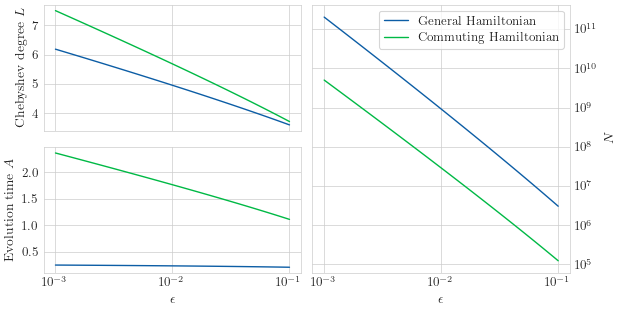

In [3]:
fig, axd = plt.subplot_mosaic([['uleft', 'right'],
                               ['lleft', 'right']],
                              figsize=(width*0.95,width*0.95*0.5), constrained_layout=True, sharex=True)

axd['right'].loglog(epss, configs[:,2], label='General Hamiltonian')
axd['uleft'].semilogx(epss, configs[:,0])
axd['lleft'].semilogx(epss, configs[:,1])

axd['right'].loglog(epss, configs_comm[:,2], label='Commuting Hamiltonian')
axd['uleft'].semilogx(epss, configs_comm[:,0])
axd['lleft'].semilogx(epss, configs_comm[:,1])

axd['right'].legend(frameon=True)

axd['right'].yaxis.tick_right()
axd['right'].yaxis.set_label_position("right")
axd['right'].tick_params(axis=u'both', which=u'both',width=0)

axd['uleft'].set_ylabel('Chebyshev degree $L$')
axd['lleft'].set_ylabel(r'Evolution time $A$')
axd['right'].set_ylabel(r'$N$')
axd['lleft'].set_xlabel(r'$\epsilon$')
axd['right'].set_xlabel(r'$\epsilon$')

axd['right'].yaxis.set_ticks_position('none')
axd['right'].xaxis.set_ticks_position('none')
axd['uleft'].yaxis.set_ticks_position('none')
axd['uleft'].xaxis.set_ticks_position('none')
axd['lleft'].yaxis.set_ticks_position('none')
axd['lleft'].xaxis.set_ticks_position('none')

fig.savefig('figures/error-bound.pdf', bbox_inches='tight')

In [4]:
def ising_model(N, h1, h2):
    G = nx.Graph()
    for i in range(N):
        G.add_node(f'$Z_{{{i}}}$', sites=(i,), term='Z', weight=h1[i]) # (0,i) is the node ID - has no explicit meaning
    for i in range(N-1):
        G.add_node(f'$XX_{{{i},{i+1}}}$', sites=(i,i+1), term='XX', weight=h2[i]) # (1,i) is the node ID - has no explicit meaning
        G.add_edge(f'$XX_{{{i},{i+1}}}$', f'$Z_{{{i}}}$')
        G.add_edge(f'$XX_{{{i},{i+1}}}$', f'$Z_{{{i+1}}}$')
        if i > 0: G.add_edge(f'$XX_{{{i},{i+1}}}$', f'$XX_{{{i-1},{i}}}$')
    G.N = N
    return G

def construct_hamiltonian(G, return_builder=False):
    # Supports only nearest neighbor 2-body interactions.
    builder = qtn.SpinHam1D(S=1/2)
    for idx, node in G.nodes(data=True):
        sites, term = node['sites'], node['term']
        if len(sites) == 2:
            builder[sites[0],sites[1]] += 4*node['weight'], term[0], term[1]
        elif len(sites) == 1:
            builder[sites[0]] += 2*node['weight'], term[0]
    return builder if return_builder else builder.build_local_ham(G.N)

def get_pam(G, partition): # get prepare-and-measure configuration
    z_stabilizers = np.linalg.eigh(pauli('Z'))[1]    
    state = [z_stabilizers[:,np.random.choice(len(z_stabilizers))] for _ in range(G.N)] # everything starts as maximally mixed
    obs_map = {'X': 'Z', 'Z': 'X', 'Y': 'X'}
    observables = {}
    for idx in partition:
        node = G.nodes[idx]
        term, sites = node['term'], node['sites']
        obs = obs_map[term[0]]
        comm = -1j*qi.Pauli(term).compose(qi.Pauli(obs+'I'*(len(sites)-1)))
        for i, site in enumerate(sites):
            eig_idx = 1
            if i == 0 and comm.phase == 2: # Take the -1 eigenvector if the commutator has a negative sign
                eig_idx = 0
            # qiskit reverses site convention, so we use comm[-(i+1)] rather than comm[i]
            state[site] = np.linalg.eigh(comm[-(i+1)].to_matrix())[1][:,eig_idx] # Get the +1 eigenvector
        observables[idx] = (sites[0], obs)
    state = qtn.MPS_product_state(state)
    state.normalize()
    return state, observables


@functools.cache
def collect_data(G, times):
    colors = nx.greedy_color(nx.power(G,2))
    partitions = inv_map(colors).values()
    hamiltonian = construct_hamiltonian(G)
    data = {idx: [] for idx in G.nodes}
    for partition in partitions:
        state, observables = get_pam(G, partition)
        tebd = qtn.TEBD(state, hamiltonian)
        tebd.split_opts['cutoff'] = 1e-13
        err = []
        for psit in tebd.at_times(times, tol=1e-9, progbar=False):
            for idx, (site, obs) in observables.items():
                data[idx].append(psit.magnetization(i=site, direction=obs))
    return data

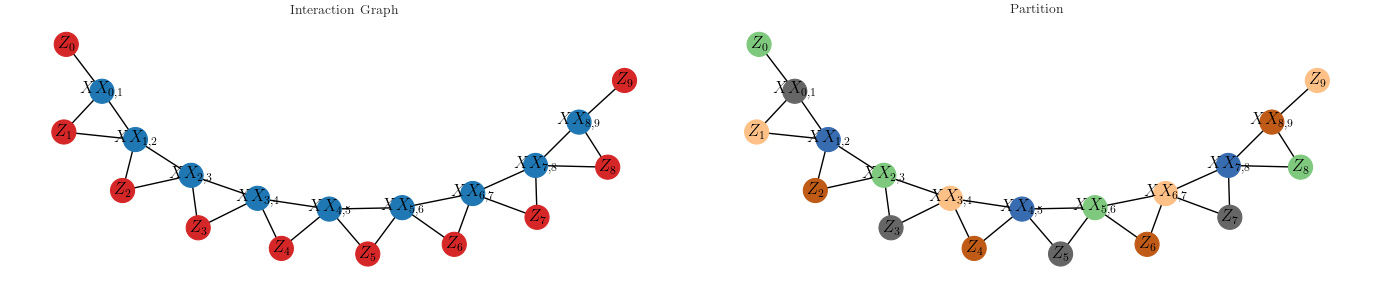

In [6]:
N = 10
G = ising_model(N, np.random.uniform(-1,1,size=N), np.random.uniform(-1,1,size=N-1))
fig = plt.figure(figsize=(14,3))
plt.subplot(121)
plt.title('Interaction Graph')
nx.draw_kamada_kawai(G, with_labels=True, node_color=['tab:red' if 'Z' in idx else 'tab:blue' for idx in G.nodes])
plt.subplot(122)
colors = nx.greedy_color(nx.power(G,2))
partitions = inv_map(colors)
plt.title('Partition')
nx.draw_kamada_kawai(G, with_labels=True, node_color=[colors[i] for i in G.nodes], cmap='Accent')
hamiltonian = construct_hamiltonian(G)
fig.tight_layout()
fig.savefig('figures/int-graph.png', bbox_inches='tight')

Sanity check on prepare-and-measure configuration: observables should approximately follow the dashed line for small times.

t=0.4, max-bond=3: 100%|#######################################################| 20/20 [00:00<00:00, 20.80it/s]


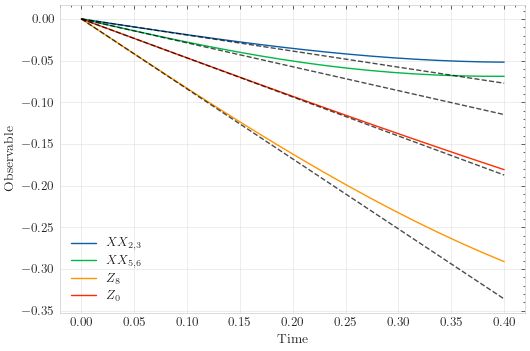

In [14]:
state, observables = get_pam(G, partitions[0])
tebd = qtn.TEBD(state, hamiltonian)
tebd.split_opts['cutoff'] = 1e-13
expvals = []
times = np.linspace(0,0.4,20)
for psit in tebd.at_times(times, tol=1e-9):
    expvals.append([])
    for (site, obs) in observables.values():
        expvals[-1].append(psit.magnetization(direction=obs, i=site))
expvals = np.real(expvals)
plt.figure(figsize=(6,4))
plt.plot(times, expvals, label=observables.keys());
coeffs = np.array([G.nodes[idx]['weight'] for idx in observables.keys()])
plt.plot(times, coeffs*times[:,None], ls='--', c='black', lw=1, alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Observable')
plt.legend()

In [15]:
np.random.seed(0)
N = 80
G = ising_model(N, np.random.uniform(-1,1,size=N), np.random.uniform(-1,1,size=N-1))

In [16]:
def ham_learn(G, eps, delta, add_noise=False, optimizations=[False,False,False]):
    D = np.mean([G.degree(idx) for idx in G.nodes])/2 if optimizations[0] else max([G.degree(idx) for idx in G.nodes])
    tau = 1/(2*D)
    
    L, A, N_shots = get_optimal_config(eps*tau, delta, n_steps=300)
    L, N_shots = int(L), int(N_shots)
    A = A * tau
    preds = {}
    
    m = np.arange(L)[:,None]
    ts = cheb_times(A, L)
    err = []
    chebs = []
    for l in range(L):
        coeff = np.zeros(L)
        coeff[l] = 1
        chebs.append(np.polynomial.chebyshev.Chebyshev(coef=coeff, domain=(0, A))(ts))
    chebs = np.array(chebs)
    m = np.arange(1, L)
    coeffs = np.sqrt(np.sum((((-1)**m * m**2)[:,np.newaxis] * chebs[1:,:]), axis=0)**2)
    N_opt = (N_shots * len(coeffs) * coeffs/np.sum(coeffs)) if optimizations[2] else N_shots
    m = np.arange(L)
    data = collect_data(G, tuple(ts))
    for idx, expvals in data.items():
        obs_vals = np.real(expvals)
        p = (obs_vals+1)/2
        if add_noise:
            obs_vals += np.random.normal(scale=2/np.sqrt(N_opt) * np.sqrt(p*(1-p)))
        coeffs = 2*(chebs @ obs_vals)/L
        coeffs[0] /= 2

        def poly(x, *c):
            return np.sum([c[i-1]*x**i for i in range(1,L)], axis=0)

        popt, pcov = scipy.optimize.curve_fit(poly, xdata=ts, ydata=obs_vals, sigma=(2/np.sqrt(N_opt) * np.sqrt(p*(1-p))), p0=np.zeros(L-1))

        preds[idx] = popt[0] if optimizations[1] else (-2/A *np.sum((-1)**m * m**2 * coeffs))
    bias_est = 4*L**2*(L+1)*(A/tau/4)**L/A
    noise_est = np.sqrt(16/(L**2 * A**2) * np.sum(np.sum((-1)**m * m**2 * chebs, axis=0)[:,None]**2, axis=0)/N_shots)
    return preds, bias_est, noise_est

In [17]:
eps = 0.01#inversefunc(lambda eps: get_optimal_config(np.squeeze(eps).item(), 0.5)[0], y_values=3, domain=(0, 1))
no_noise, _, _ = ham_learn(G, eps, 0.5, add_noise=False, optimizations=[False,False,False])
noisy, bias, noise = ham_learn(G, eps, 0.5, add_noise=True, optimizations=[False,False,False])

/opt/homebrew/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


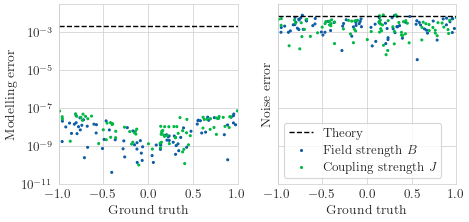

In [47]:
truth = np.array([G.nodes[idx]['weight'] for idx, _ in no_noise.items()])

fig, axes = plt.subplots(1, 2, figsize=(width * 0.75,width/ratio * 0.6), sharey=True, sharex=True)
pred = np.array([pred for _, pred in no_noise.items()])
axes[0].scatter(truth, np.abs(truth-pred), marker='o', s=2,  c=['C0' if 'Z' in idx else 'C1' for idx in no_noise.keys()])
axes[0].axhline(bias, c='black', ls='--')
axes[0].set_yscale('log')
pred = np.array([pred for _, pred in noisy.items()])
axes[1].scatter(truth, np.abs(truth-pred), marker='o', s=2,  c=['C0' if 'Z' in idx else 'C1' for idx in noisy.keys()])
axes[1].axhline(noise, c='black', ls='--', label='Theory')
axes[1].set_xlim(-1,1)
axes[0].set_ylim(1e-11)
axes[1].scatter(10,1,label=r'Field strength $B$', s=2, c='C0') # Dummy point
axes[1].scatter(10,1,label=r'Coupling strength $J$', s=2, c='C1') # Dummy point

for i in range(2):
    axes[i].set_xlabel('Ground truth')
    axes[i].set_xlim(-1,1)
    axes[i].xaxis.set_ticks_position('none')
    axes[i].yaxis.set_ticks_position('none')
axes[1].legend(frameon=True)


axes[0].set_ylabel('Modelling error')
axes[1].set_ylabel('Noise error')
fig.tight_layout()
fig.savefig('figures/model-err-rig.pdf', bbox_inches='tight')

In [18]:
import multiprocess as mp
import pickle
import os
if not os.path.exists('sim.pickle'):
    np.random.seed(0)
    N = 80
    reps = 200
    Gs = [ising_model(N, np.random.uniform(-1,1,size=N), np.random.uniform(-1,1,size=N-1)) for _ in range(reps)]
    rec = []
    Ls = list(range(2,8))
    pool = mp.Pool(len(Ls))
    def f(L):
        eps = inversefunc(lambda eps: get_optimal_config(np.squeeze(eps).item(), 0.1, n_steps=300)[0], y_values=L, domain=(0, 1))
        rec = []
        for i in trange(reps):
            G = Gs[i]
            residual = lambda results: np.max(np.abs([results[idx]-G.nodes[idx]['weight'] for idx in G.nodes]))
            rec.append([
                residual(ham_learn(G, eps, 0.1, add_noise=True, optimizations=[True,False,False])[0]),
                residual(ham_learn(G, eps, 0.1, add_noise=True, optimizations=[True,False,True])[0]),
                residual(ham_learn(G, eps, 0.1, add_noise=True, optimizations=[True,True,False])[0]),
                residual(ham_learn(G, eps, 0.1, add_noise=True, optimizations=[True,True,True])[0]),
            ])
        return np.array(rec)
    rec = np.array(pool.map(f, Ls))
    Ls = list(range(2,8))
    with open('sim.pickle', 'wb+') as f:
        pickle.dump(f, {'errs': rec, 'Ls': Ls, 'Gs': Gs, 'delta': 0.1})
else:
    with open('sim.pickle', 'rb+') as f:
        rec = np.array(pickle.load(f)['errs']) 

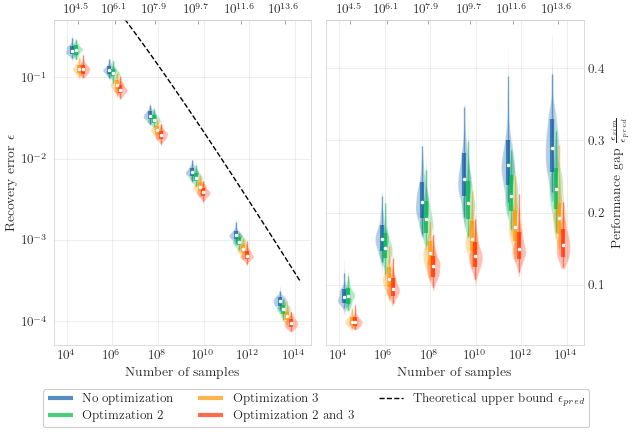

In [19]:
from matplotlib import ticker as mticker

eps = np.array([inversefunc(lambda eps: get_optimal_config(np.squeeze(eps).item(), 0.1, n_steps=300)[0], y_values=L, domain=(0, 1)).item() for L in range(2,8)])
D = np.mean([G.degree(idx) for idx in G.nodes])/2
tau = 1/(2*D)
Ns = [get_optimal_config(ep, 0.1, n_steps=300)[-1] for ep in eps]
n_partitions = len(set(nx.greedy_color(nx.power(G, 2)).values()))
Nshots = np.log10(Ns)+np.log10(n_partitions)

fig, (ax0, ax1) = plt.subplots(1,2,sharex=True,figsize=(width,width/ratio))
dx = -0.24
labels = ['No optimization', 'Optimzation 2', 'Optimization 3', 'Optimization 2 and 3']
for i in range(4):
    q0, q1, q2, q3, q4 = np.log10(np.percentile(rec[:,:,i], [1,16,50,84,99], axis=1))
    ax0.violinplot(np.log10(rec[:,:,i].T), positions=Nshots+dx, widths=0.6, showextrema=False)
    ax0.vlines(Nshots+dx, q1, q3, color=f'C{i}', ls='-', lw=3, alpha=0.7, label=labels[i])
    ax0.vlines(Nshots+dx, q0, q4, color=f'C{i}', ls='-', lw=1, alpha=0.5)
    ax0.scatter(Nshots+dx, q2, marker='o', color='white', s=3, zorder=3)
    dx += 0.16

dx = -0.24
for i in range(4):
    q0, q1, q2, q3, q4 = np.percentile(rec[:,:,i]/(eps[:,None]/tau), [1,16,50,84,99], axis=1)
    ax1.violinplot((rec[:,:,i]/(eps[:,None]/tau)).T, positions=Nshots+dx, widths=0.6, showextrema=False)
    ax1.vlines(Nshots+dx, q1, q3, color=f'C{i}', ls='-', lw=3, alpha=0.7)
    ax1.vlines(Nshots+dx, q0, q4, color=f'C{i}', ls='-', lw=1, alpha=0.5)
    ax1.scatter(Nshots+dx, q2, marker='o', color='white', s=3, zorder=3)
    dx += 0.16


ax0.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ax0.set_yticks([-4,-3,-2,-1,0])
ax0.yaxis.set_ticks([np.log10(x) for p in np.arange(-4,0) for x in np.linspace(10. ** p, 10. ** (p + 1), 10)], minor=True);
ax0.set_ylim(-4.3, -0.3)

ax0.xaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ax0.xaxis.set_ticks([np.log10(x) for p in np.arange(4,14) for x in np.linspace(10. ** p, 10. ** (p + 1), 10)], minor=True);


eps = np.logspace(-3.5, 0.5)
Ns = np.log10([get_optimal_config(ep*tau, 0.1, n_steps=300)[-1] for ep in eps]) + np.log10(n_partitions)
ax0.plot(Ns, np.log10(eps), ls='--', c='black', label=r'Theoretical upper bound $\epsilon_{pred}$')

for axi in [ax0,ax1]:
    secax = axi.secondary_xaxis('top')
    secax.set_xticks(Nshots, [f'$10^{{{ns:.1f}}}$' for ns in Nshots])
    secax.tick_params(length=3, color='grey', direction='in')
    secax.tick_params(length=0, which='minor')
    axi.set_xlabel(r'Number of samples')
    axi.xaxis.set_ticks_position('none')
    axi.yaxis.set_ticks_position('none')

ax0.set_ylabel(r'Recovery error $\epsilon$')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_ylabel(r'Performance gap $\frac{\epsilon_{sim}}{\epsilon_{pred}}$')
ax1.yaxis.set_ticks_position('none')
fig.legend(ncol=3, bbox_to_anchor=(0.5,-0.1), loc='lower center', frameon=True)
fig.tight_layout()
fig.savefig('figures/err.pdf', bbox_inches='tight')

In [24]:
def it_comm(A, B, n=1):
    ret = B
    for i in range(n):
        ret = A@ret - ret@A
    return ret

def tensor_prod(lst):
    ret = pauli(lst[0])
    for i in range(1, len(lst)):
        ret = ret & pauli(lst[i])
    return ret

In [14]:
Ns = np.arange(1, 10).astype(int)
to_plt = []
for n_qubits in trange(2, 8):
    norms = []
    for i in range(200):
        a, b = np.random.uniform(0,1,size=n_qubits), np.random.uniform(0,1,size=n_qubits+1)
        theta_inf = max(np.max(np.abs(a)), np.max(np.abs(b)))
        a/=theta_inf
        b/=theta_inf
        a, b = np.ones_like(a), np.ones_like(b)
        G = ising_model(n_qubits, a,b)
        H = construct_hamiltonian(G, return_builder=True).build_sparse(G.N).toarray()
        ps = ['I']*n_qubits
        ps[np.random.choice(n_qubits)] = np.random.choice(['X', 'Z'])
        P = tensor_prod(ps)
        norms.append(np.array([np.linalg.norm(it_comm(H, P, n=n), ord=2) for n in Ns]))
#         norms.append(np.array([np.mean(np.abs(np.linalg.eigvalsh(it_comm(H, P, n=n)))) for n in Ns]))
    norms = np.abs(np.squeeze(np.array(norms)))
    to_plt.append(np.max(norms, axis=0))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:19<00:00,  3.21s/it]


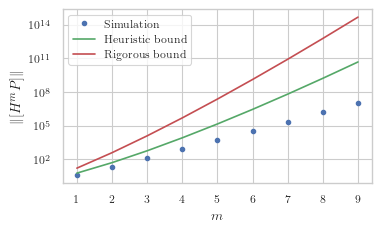

In [15]:
plt.figure(figsize=(width * 0.6,width/ratio * 0.6))
plt.plot(Ns, np.max(to_plt, axis=0), label='Simulation', ls='none', marker='o', markersize=3)
plt.plot(Ns, ((2*2.8729/2)**(Ns)) * scipy.special.factorial(Ns+1), label='Heuristic bound')

plt.plot(Ns, ((2*4)**(Ns)) * scipy.special.factorial(Ns+1), label='Rigorous bound')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$m$')
plt.ylabel(r'$\left\Vert \left[H^m P\right] \right\Vert$')
plt.tight_layout()